# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

# Importations

In [363]:
# Libraries for data preparation
import re
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif, SelectKBest

# Libraries for Modeling
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

# Libraries for Testing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# Libraries for visualisation
import matplotlib.pyplot as plt
import seaborn as sns

In [364]:
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Data cleansing

### The portfolio dataframe needs no cleansing no duplicates or nulls

In [365]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [366]:
print(portfolio.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes
None


In [367]:
print(portfolio.describe())

       difficulty   duration     reward
count   10.000000  10.000000  10.000000
mean     7.700000   6.500000   4.200000
std      5.831905   2.321398   3.583915
min      0.000000   3.000000   0.000000
25%      5.000000   5.000000   2.000000
50%      8.500000   7.000000   4.000000
75%     10.000000   7.000000   5.000000
max     20.000000  10.000000  10.000000


[[<matplotlib.axes._subplots.AxesSubplot object at 0x7f56a274beb8>


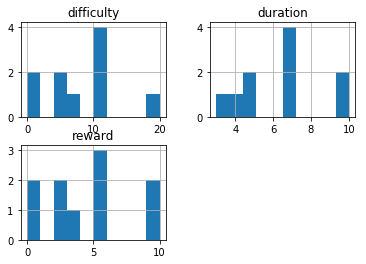

In [368]:
print(portfolio.hist())

In [369]:
# No nulls for portofolio
print("portfolio")
print(portfolio.isnull().sum())

portfolio
channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64


In [370]:
# we have no duplicates 
print(portfolio['id'].duplicated().any())

False


### The Profile dataframe cleansing

In [371]:
# profile.shape
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [372]:
print(profile.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB
None


In [373]:
print(profile.describe())

                age  became_member_on         income
count  17000.000000      1.700000e+04   14825.000000
mean      62.531412      2.016703e+07   65404.991568
std       26.738580      1.167750e+04   21598.299410
min       18.000000      2.013073e+07   30000.000000
25%       45.000000      2.016053e+07   49000.000000
50%       58.000000      2.017080e+07   64000.000000
75%       73.000000      2.017123e+07   80000.000000
max      118.000000      2.018073e+07  120000.000000


[[<matplotlib.axes._subplots.AxesSubplot object at 0x7f56c14a33c8>


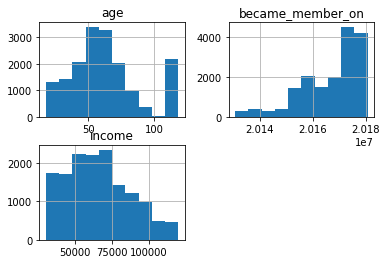

In [374]:
print(profile.hist())

In [375]:
print("profile")
print(profile.isnull().sum())

profile
age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64


In [234]:
# Replace missing values in 'income' column with the mean
profile['income'].fillna((profile['income'].mean()), inplace=True)

In [376]:
# Replace missing values in 'gender' column with the O 'others'
profile['gender'] = profile['gender'].fillna('O')

In [391]:
# impute the missing ages taht are labeled 118 by mean to avoid outliers
profile['age'] = profile['age'].replace(118, profile['age'].mean())

In [392]:
profile.head()

,age,became_member_on,gender,id,income
0,62.531412,20170212,O,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55.000000,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,62.531412,20180712,O,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75.000000,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,62.531412,20170804,O,a03223e636434f42ac4c3df47e8bac43,NaN


In [393]:
# we have no duplicates 
print(profile['id'].duplicated().any())

False


### The Transcript dataframe cleansing

In [394]:
transcript.head(5)

,event,id,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [395]:
print(transcript.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event    306534 non-null object
id       306534 non-null object
time     306534 non-null int64
value    306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB
None


In [396]:
print(transcript.describe())

                time
count  306534.000000
mean      366.382940
std       200.326314
min         0.000000
25%       186.000000
50%       408.000000
75%       528.000000
max       714.000000


In [397]:
print("transcript")
print(transcript.isnull().sum())

transcript
event    0
id       0
time     0
value    0
dtype: int64


In [398]:
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

# Data Understanding

### 1. How does age affect the likelihood of completing an offer?

In [399]:
transcript.rename(columns = {'person':'id'}, inplace = True)

In [400]:
analysis = transcript.merge(profile, on='id')

In [401]:
analysis.columns

Index(['event', 'id', 'time', 'value', 'age', 'became_member_on', 'gender',
       'income'],
      dtype='object')

In [402]:
analysis.head()

,event,id,time,value,age,became_member_on,gender,income
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},75.0,20170509,F,100000.0
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},75.0,20170509,F,100000.0
2,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,{'amount': 19.89},75.0,20170509,F,100000.0
3,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,75.0,20170509,F,100000.0
4,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,{'amount': 17.78},75.0,20170509,F,100000.0


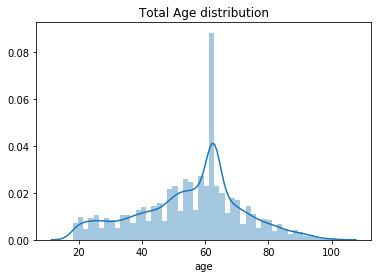

In [403]:
# First lets know the age distribution
age_dist = sns.distplot(profile['age']);
age_dist.set_title('Total Age distribution');

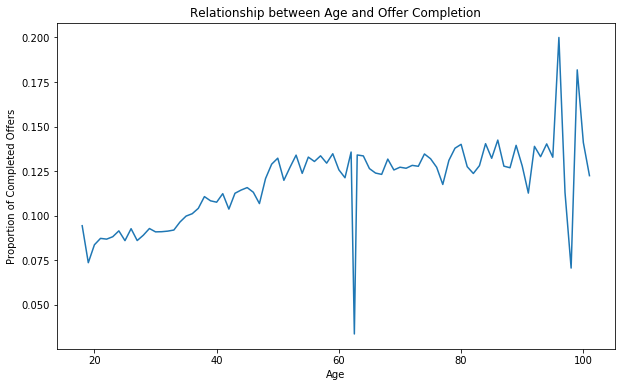

In [404]:
import matplotlib.pyplot as plt

# Assuming you have the relevant data stored in a pandas DataFrame called 'data'
age_completion = analysis[analysis['event'] == 'offer completed'].groupby('age').size() / analysis.groupby('age').size()
age = age_completion.index

plt.figure(figsize=(10, 6))
plt.plot(age, age_completion)
plt.xlabel('Age')
plt.ylabel('Proportion of Completed Offers')
plt.title('Relationship between Age and Offer Completion')
plt.show()

**We can detect a reduction in the 60s and close to 100 years old, and we can deduce from the plot that as people age, their chance of accepting an offer will also increase.**

### 2. How does gender determine the amount spent in transactions?

In [276]:
analysis.head()

,event,id,time,value,age,became_member_on,gender,income
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},75.0,20170509,F,100000.0
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},75.0,20170509,F,100000.0
2,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,{'amount': 19.89},75.0,20170509,F,100000.0
3,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,75.0,20170509,F,100000.0
4,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,{'amount': 17.78},75.0,20170509,F,100000.0


In [277]:
# split "value" column into separate columns
split_values = analysis['value'].apply(lambda x: pd.Series(str(x).split(":")))
split_values = split_values.rename(columns={0: "type", 1: "value"})

# concatenate original dataframe with split values dataframe
new_dataframe = pd.concat([analysis.drop(['value'], axis=1), split_values], axis=1)

In [278]:
# remove unnecessary characters from "type" and "value" columns
new_dataframe['type'] = new_dataframe['type'].str.replace("{", "").str.replace("'", "").str.strip()
new_dataframe['value'] = new_dataframe['value'].str.replace("}", "").str.strip()


In [279]:
# display resulting dataframe
new_dataframe.head()

,event,id,time,age,became_member_on,gender,income,type,value,2
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,75.0,20170509,F,100000.0,offer id,'9b98b8c7a33c4b65b9aebfe6a799e6d9',NaN
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,75.0,20170509,F,100000.0,offer id,'9b98b8c7a33c4b65b9aebfe6a799e6d9',NaN
2,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,75.0,20170509,F,100000.0,amount,19.89,NaN
3,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,75.0,20170509,F,100000.0,offer_id,"'9b98b8c7a33c4b65b9aebfe6a799e6d9', 'reward'",5}
4,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,75.0,20170509,F,100000.0,amount,17.78,NaN


In [280]:
merged_dataframe = pd.merge(new_dataframe, analysis, on='id', suffixes=('_val', '_user'))

In [281]:
merged_dataframe_1 = merged_dataframe[merged_dataframe['type'] == 'amount']

In [282]:
purchasement_by_gender = merged_dataframe_1[['value_val','gender_user']]

In [283]:
purchasement_by_gender = purchasement_by_gender.astype({'value_val':'float'})

In [284]:
purchasement_by_gender.groupby(['gender_user']).mean()['value_val'].sort_values().dropna()

gender_user
O     4.230061
M    11.377245
F    17.021546
Name: value_val, dtype: float64

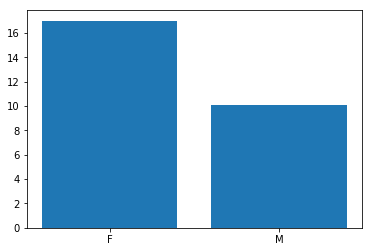

In [285]:
fig = plt.figure()

gender = ['M', 'F']
average_payment = [10.096883,17.021546]
plt.bar(gender,average_payment)
plt.show()

**The bar layout demonstrates that women pay more money than men do may suggest that women are more responsive to offers.**

### 3. Are there any age-related differences in the preferred channels for receiving offers (e.g., web, email, mobile, social)?

In [286]:
new_dataframe.head()

,event,id,time,age,became_member_on,gender,income,type,value,2
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,75.0,20170509,F,100000.0,offer id,'9b98b8c7a33c4b65b9aebfe6a799e6d9',NaN
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,75.0,20170509,F,100000.0,offer id,'9b98b8c7a33c4b65b9aebfe6a799e6d9',NaN
2,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,75.0,20170509,F,100000.0,amount,19.89,NaN
3,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,75.0,20170509,F,100000.0,offer_id,"'9b98b8c7a33c4b65b9aebfe6a799e6d9', 'reward'",5}
4,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,75.0,20170509,F,100000.0,amount,17.78,NaN


In [287]:
merged_dataframe_2 = merged_dataframe[merged_dataframe['type'] == 'offer_id']

In [288]:
merged_dataframe_2.head()

,event_val,id,time_val,age_val,became_member_on_val,gender_val,income_val,type,value_val,2,event_user,time_user,value_user,age_user,became_member_on_user,gender_user,income_user
54,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,75.0,20170509,F,100000.0,offer_id,"'9b98b8c7a33c4b65b9aebfe6a799e6d9', 'reward'",5},offer received,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},75.0,20170509,F,100000.0
55,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,75.0,20170509,F,100000.0,offer_id,"'9b98b8c7a33c4b65b9aebfe6a799e6d9', 'reward'",5},offer viewed,6,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},75.0,20170509,F,100000.0
56,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,75.0,20170509,F,100000.0,offer_id,"'9b98b8c7a33c4b65b9aebfe6a799e6d9', 'reward'",5},transaction,132,{'amount': 19.89},75.0,20170509,F,100000.0
57,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,75.0,20170509,F,100000.0,offer_id,"'9b98b8c7a33c4b65b9aebfe6a799e6d9', 'reward'",5},offer completed,132,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,75.0,20170509,F,100000.0
58,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,75.0,20170509,F,100000.0,offer_id,"'9b98b8c7a33c4b65b9aebfe6a799e6d9', 'reward'",5},transaction,144,{'amount': 17.78},75.0,20170509,F,100000.0


In [289]:
merged_dataframe_2.rename(columns = {'type':'offer_id'}, inplace = True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [290]:

# extract first 11 characters (assuming they are always the same length)
merged_dataframe_2['value_val'] = merged_dataframe_2['value_val'].str.extract('(\w{32})')


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [291]:
merged_dataframe_2.drop('offer_id',inplace= True,axis=1)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [292]:
# rename value_val to offer_id
merged_dataframe_2.rename(columns = {'value_val':'offer_id'}, inplace = True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [293]:
merged_dataframe_2.head(1)

,event_val,id,time_val,age_val,became_member_on_val,gender_val,income_val,offer_id,2,event_user,time_user,value_user,age_user,became_member_on_user,gender_user,income_user
54,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,75.0,20170509,F,100000.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5},offer received,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},75.0,20170509,F,100000.0


In [294]:
portfolio.rename(columns = {'id':'offer_id'}, inplace = True)

In [295]:
analysis_comm = merged_dataframe_2.merge(portfolio,on='offer_id')

In [296]:
analysis_comm = analysis_comm[['age_user', 'channels', 'offer_type', 'event_user']]

In [297]:
# to drop missing data
analysis_comm = analysis_comm[analysis_comm['age_user']!=118]

In [298]:
#  split channels into separate columns
analysis_comm = pd.concat([analysis_comm, analysis_comm['channels'].str.join('|').str.get_dummies()], axis=1)


In [299]:
# drop original 'channels' column
analysis_comm = analysis_comm.drop('channels', axis=1)

In [300]:
analysis_comm.head()

,age_user,offer_type,event_user,email,mobile,social,web
0,75.0,bogo,offer received,1,1,0,1
1,75.0,bogo,offer viewed,1,1,0,1
2,75.0,bogo,transaction,1,1,0,1
3,75.0,bogo,offer completed,1,1,0,1
4,75.0,bogo,transaction,1,1,0,1


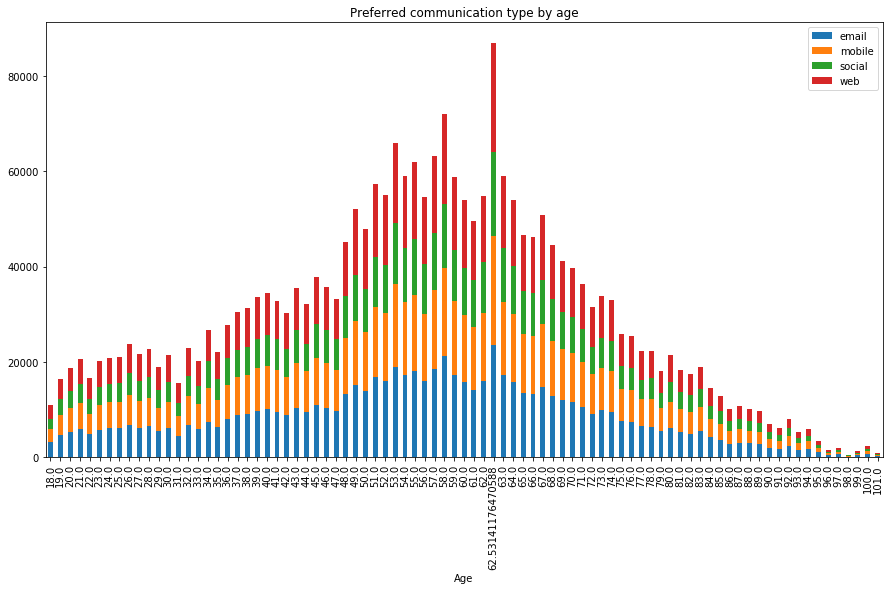

In [301]:
# group data by age and communication type
grouped = analysis_comm.groupby(['age_user']).sum()

# create stacked bar plot with custom figure size
fig, ax = plt.subplots(figsize=(15, 8))
grouped.plot(kind='bar', stacked=True, ax=ax)

# set plot title and axis labels
ax.set_title('Preferred communication type by age')
ax.set_xlabel('Age')
# ax.set_ylabel('Count')

# display plot
plt.show()

**Ages 45 to 75 would like the offer to come by email, but it practically doesn't matter what form of contact it is.**

### 4. What kind of offer receives the highest completion rate?

In [302]:
completed_offers = analysis_comm[['offer_type','event_user']]

In [303]:
completed_offers = completed_offers[completed_offers['event_user'] == 'offer completed']

In [304]:
completed_offers.groupby(['offer_type']).count()['event_user'].sort_values().dropna()

offer_type
bogo        52191
discount    57956
Name: event_user, dtype: int64

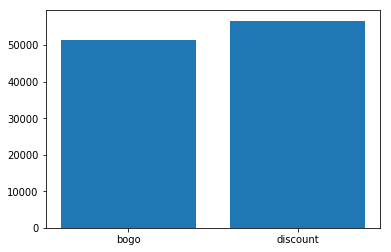

In [305]:
fig = plt.figure()

offer_type = ['bogo', 'discount']
count = [51439,56673]
plt.bar(offer_type,count)
plt.show()

**No big surprise! Who wouldn't want a decent discount for their morning coffee :) Perhaps this is why it had a higher completion rate,
It's possible that a discount offer for coffee is more appealing to customers**

### 5. what is the most offered offer type?

In [306]:
transcript.head()

,event,id,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [307]:
# extract 'offer id' from each dictionary in 'value' column
transcript['offer_id'] = transcript['value'].apply(lambda x: x['offer id'] if 'offer id' in x else None)

In [308]:
# display modified DataFrame
transcript.drop('value',axis=1,inplace=True)

In [309]:
data = transcript['offer_id'].value_counts()

In [310]:
data = pd.DataFrame(data)
data.reset_index(inplace=True)

In [311]:
data = data.rename(columns={'index': "offer_id", 'offer_id': "count"})

In [312]:
data.dtypes

offer_id    object
count        int64
dtype: object

In [313]:
most_offered = portfolio.merge(data,on = 'offer_id')

In [314]:
most_offered = most_offered[['offer_type','count']]

In [315]:
# group the DataFrame by the 'offer_type' column and compute the sum of the 'count' column
total_counts = most_offered.groupby('offer_type')['count'].sum()

# print the result
print(total_counts)

offer_type
bogo             55948
discount         51988
informational    26066
Name: count, dtype: int64


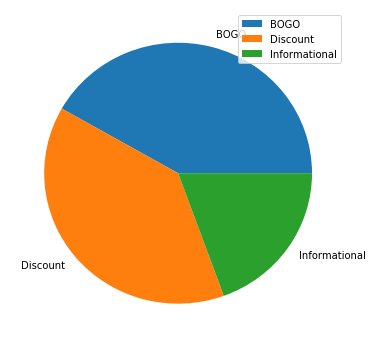

In [316]:
y = np.array([55948, 51988, 26066])
mylabels = ["BOGO", "Discount", "Informational"]

# create a new figure object with a size of 8x8 inches
fig = plt.figure(figsize=(6, 6))

# plot the pie chart and set the labels and legend
plt.pie(y, labels=mylabels)
plt.legend()

# show the plot
plt.show()

**BOGO and our preferred "Discount" offer were the two that were most frequently presented, and both of them performed best when there was a greater offer completion rate**

## Data Preparation

In [317]:
# identify customers who made transactions but did not receive any offers
transaction_only = transcript[transcript['event'] == 'transaction']['id'].unique()
purchase_only = set(transaction_only) - set(transcript[transcript['event'] == 'offer completed']['id'].unique())

# filter profile data to exclude customers who purchase without receiving offers
profile_filtered = profile[~profile['id'].isin(purchase_only)]

# display filtered profile data
profile_filtered.head()

,age,became_member_on,gender,id,income
0,62.531412,20170212,O,68be06ca386d4c31939f3a4f0e3dd783,65404.991568
1,55.000000,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.000000
3,75.000000,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.000000
5,68.000000,20180426,M,e2127556f4f64592b11af22de27a7932,70000.000000
6,62.531412,20170925,O,8ec6ce2a7e7949b1bf142def7d0e0586,65404.991568


In [318]:
# merge profile_filtered and transcript data
transcript_filtered = pd.merge(profile_filtered[['id']], transcript, on='id')

In [319]:
transcript_filtered.head()

,id,event,time,offer_id
0,68be06ca386d4c31939f3a4f0e3dd783,offer received,168,2906b810c7d4411798c6938adc9daaa5
1,68be06ca386d4c31939f3a4f0e3dd783,offer viewed,216,2906b810c7d4411798c6938adc9daaa5
2,68be06ca386d4c31939f3a4f0e3dd783,offer received,336,0b1e1539f2cc45b7b9fa7c272da2e1d7
3,68be06ca386d4c31939f3a4f0e3dd783,offer viewed,348,0b1e1539f2cc45b7b9fa7c272da2e1d7
4,68be06ca386d4c31939f3a4f0e3dd783,transaction,360,None


In [320]:
new_Df = transcript.merge(profile, on='id')

In [321]:
new_Df['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [322]:
# wether or not complete it - 33579

In [323]:
# encode data to have 1 if 'offer completed' and 0 otherwise 
# to help predict wether someone will complete the offer or not

new_Df['event'] = pd.Series([1 if 'offer completed' in i else 0
                            for i in new_Df['event']])


In [324]:
new_Df.isnull().sum()

event                    0
id                       0
time                     0
offer_id            172532
age                      0
became_member_on         0
gender                   0
income                   0
dtype: int64

In [325]:
new_Df = new_Df.drop('offer_id', axis=1)

In [326]:
# encoding and scaling 
# using label encoder to handle categorical data by encoding them
# Used standard scaler to scale data to prevent any bias
new_Df = new_Df.apply(LabelEncoder().fit_transform)
scaler = StandardScaler()
scaler.fit_transform(new_Df)
new_Df = pd.DataFrame(new_Df)

In [327]:
# Separate the features and target variable
X = new_Df.drop('event', axis=1)
y = new_Df['event']

# Use mutual information to select the top k features
k = 3 # Set the number of top features to select
selector = SelectKBest(mutual_info_classif, k=k)
selector.fit(X, y)

# Get the indices of the selected features
selected_features_indices = selector.get_support(indices=True)

# Get the names of the selected features
selected_features_names = X.columns[selected_features_indices]

# Print the names of the selected features
print(selected_features_names)

Index(['time', 'gender', 'income'], dtype='object')


# Modeling & Visualisation

## KNN

***Using best 3 features***

In [361]:
# Using best 3 features recommended
X = new_Df[['time', 'gender', 'income']]
y = new_Df['event']

# split the data into training and testing sets
X_3_train, X_3_test, y_3_train, y_3_test = train_test_split(X, y, test_size=0.3, random_state=42)

# KNN Classifier
knn = KNeighborsClassifier()

In [362]:
# Perform 10-fold cross-validation on the training set
kf = KFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(knn, X_3_train, y_3_train, cv=kf)

# Print the cross-validation scores for each fold
print("Cross-validation scores:", cv_scores)

# Compute the mean and standard deviation of the cross-validation scores
mean_score = cv_scores.mean()
std_score = cv_scores.std()
print("Mean cross-validation score:", mean_score)
print("Standard deviation of cross-validation scores:", std_score)

# Fit the classifier to the training data
knn.fit(X_3_train, y_3_train)

# Predict the classes for the testing data
y_pred = knn.predict(X_3_test)

# Compute the accuracy score of the model on the testing data
accuracy = accuracy_score(y_3_test, y_pred)

# Print the accuracy score
print("Accuracy score on testing data:", accuracy*100)

Cross-validation scores: [ 0.87738839  0.8740796   0.8828875   0.86890059  0.87617095  0.87733607
  0.8805052   0.87551848  0.87416694  0.87603113]
Mean cross-validation score: 0.876298483686
Standard deviation of cross-validation scores: 0.0035814514761
Accuracy score on testing data: 87.4457650526


In [329]:
# Generate a classification report
knn_report = classification_report(y_3_test,y_3_pred)
print(knn_report)

             precision    recall  f1-score   support

          0       0.89      0.98      0.93     81778
          1       0.17      0.03      0.06     10183

avg / total       0.81      0.87      0.84     91961



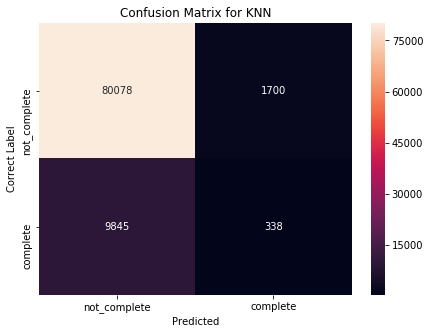

In [330]:
# Generate a confusion matrix
knn_matrix = confusion_matrix(y_3_test,y_3_pred)
plt.figure(figsize=(7,5))
plt.title('Confusion Matrix for KNN')
sns.heatmap(knn_matrix , annot=True,xticklabels=["not_complete", "complete"],
           yticklabels=["not_complete", "complete"],fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Correct Label')

plt.show()

***Using all features***

In [331]:
# Using best all features
X = new_Df.drop('event', axis=1)
y = new_Df['event']

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# KNN Classifier
knn = KNeighborsClassifier()

# Train the model
knn.fit(X_train, y_train)

# test the model
knn_y_pred = knn.predict(X_test)

# scores
print('accuracy of model is',"{:,.2f}".format(accuracy_score(y_test,knn_y_pred)*100),'%')

accuracy of model is 88.55 %


In [332]:
# Generate a classification report
knn_report = classification_report(y_test,knn_y_pred)
print(knn_report)

             precision    recall  f1-score   support

          0       0.89      1.00      0.94     81778
          1       0.01      0.00      0.00     10183

avg / total       0.79      0.89      0.84     91961



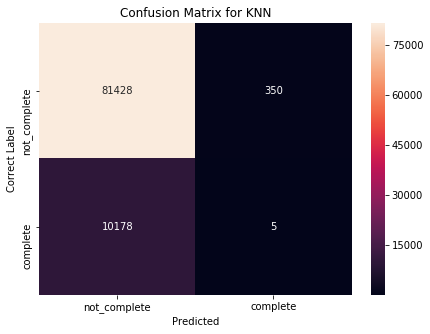

In [333]:
# Generate a confusion matrix
knn_matrix = confusion_matrix(y_test,knn_y_pred)
plt.figure(figsize=(7,5))
plt.title('Confusion Matrix for KNN')
sns.heatmap(knn_matrix , annot=True,xticklabels=["not_complete", "complete"],
           yticklabels=["not_complete", "complete"],fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Correct Label')

plt.show()

**Because the improvement in accuracy wasn't very significant, the other aspects didn't have a significant impact on it.**

## Logistic Regression

In [347]:
# Create and fit the logistic regression model
lm = LogisticRegression()

In [348]:
# Perform 10-fold cross-validation on the training set
kf = KFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(lm, X_3_train, y_3_train, cv=kf)

# Print the cross-validation scores for each fold
print("Cross-validation scores:", cv_scores)

# Compute the mean and standard deviation of the cross-validation scores
mean_score = cv_scores.mean()
std_score = cv_scores.std()
print("Mean cross-validation score:", mean_score)
print("Standard deviation of cross-validation scores:", std_score)

# Fit the classifier to the training data
lm.fit(X_3_train, y_3_train)

# Predict the classes for the testing data
y_pred = lm.predict(X_3_test)

# Compute the accuracy score of the model on the testing data
accuracy = accuracy_score(y_3_test, y_pred)

# Print the accuracy score
print("Accuracy score on testing data:", accuracy*100)

Cross-validation scores: [ 0.89295368  0.88922546  0.89542362  0.8853987   0.89131752  0.890199
  0.89439344  0.89192338  0.8873095   0.89150394]
Mean cross-validation score: 0.89096482452
Standard deviation of cross-validation scores: 0.00291342692424
Accuracy score on testing data: 88.926827677


In [349]:
LM_report = classification_report(y_3_test,lm_y_3_pred)
print(LM_report)

             precision    recall  f1-score   support

          0       0.89      1.00      0.94     81778
          1       0.00      0.00      0.00     10183

avg / total       0.79      0.89      0.84     91961



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


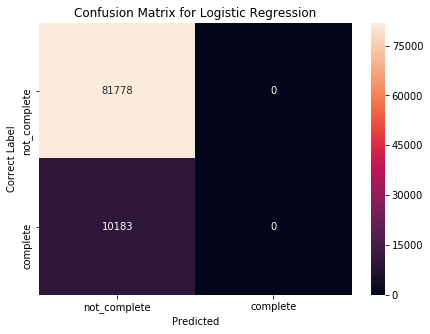

In [336]:
# Generate a confusion matrix
lm_matrix = confusion_matrix(y_3_test,lm_y_3_pred)
plt.figure(figsize=(7,5))
plt.title('Confusion Matrix for Logistic Regression')
sns.heatmap(lm_matrix , annot=True,xticklabels=["not_complete", "complete"],
           yticklabels=["not_complete", "complete"],fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Correct Label')

plt.show()

## Bayesian Classifier

In [356]:
bayesian_classifier = GaussianNB()

In [358]:
# Perform 10-fold cross-validation on the training set
kf = KFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(bayesian_classifier, X_3_train, y_3_train, cv=kf)

# Print the cross-validation scores for each fold
print("Cross-validation scores:", cv_scores)

# Compute the mean and standard deviation of the cross-validation scores
mean_score = cv_scores.mean()
std_score = cv_scores.std()
print("Mean cross-validation score:", mean_score)
print("Standard deviation of cross-validation scores:", std_score)

# Fit the classifier to the training data
bayesian_classifier.fit(X_3_train, y_3_train)

# Predict the classes for the testing data
y_pred = bayesian_classifier.predict(X_3_test)

# Compute the accuracy score of the model on the testing data
accuracy = accuracy_score(y_3_test, y_pred)

# Print the accuracy score
print("Accuracy score on testing data:", accuracy*100)

Cross-validation scores: [ 0.89295368  0.88922546  0.89542362  0.8853987   0.89131752  0.890199
  0.89439344  0.89192338  0.8873095   0.89150394]
Mean cross-validation score: 0.89096482452
Standard deviation of cross-validation scores: 0.00291342692424
Accuracy score on testing data: 88.926827677


In [359]:
bayesian_classifier_classification_report = classification_report(y_3_test,bc_y_3_pred)
print(bayesian_classifier_classification_report)

             precision    recall  f1-score   support

          0       0.89      1.00      0.94     81778
          1       0.00      0.00      0.00     10183

avg / total       0.79      0.89      0.84     91961



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


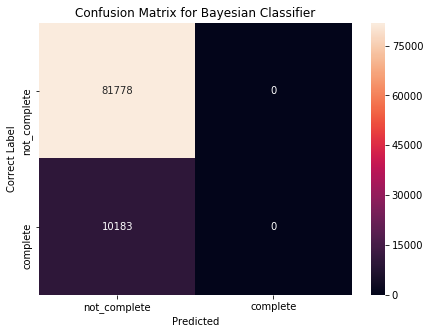

In [360]:
# Generate a confusion matrix
bc_matrix = confusion_matrix(y_3_test,bc_y_3_pred)
plt.figure(figsize=(7,5))
plt.title('Confusion Matrix for Bayesian Classifier')
sns.heatmap(bc_matrix , annot=True,xticklabels=["not_complete", "complete"],
           yticklabels=["not_complete", "complete"],fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Correct Label')

plt.show()

# Compare Models accuracy based

In [340]:
Models_Scores = pd.DataFrame({'Models':['KNN','Logistic Regression','Bayesian Classifier'],
             'Accuracy':[87.45,88.93,88.93]
                             })
Models_Scores

,Models,Accuracy
0,KNN,87.45
1,Logistic Regression,88.93
2,Bayesian Classifier,88.93


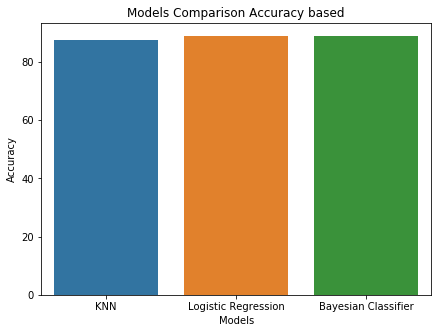

In [341]:
plt.figure(figsize=(7,5))
plt.title('Models Comparison Accuracy based')
figure = sns.barplot(x = Models_Scores['Models'],y = Models_Scores['Accuracy'])

**The differences in accuracy between the models are relatively small, with logistic regression and Bayesian classifier slightly outperforming KNN**